In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import glob
import ternary
import helpers.fileload as fl
from helpers.calc_chemfeat import perovskite, formula_redfeat, formula_pif
from helpers.plotting import quat_slice_scatter, quat_slice_heatmap, add_colorbar, sliceformula_from_tuple, rescale_ticks
from citrination_client import CitrinationClient
from ternary.helpers import simplex_iterator
import pymatgen as mg

In [59]:
tcodir = os.path.join(os.environ['HOME'],'OneDrive - Colorado School of Mines/Research/MIDDMI/TCO')
datadir = os.path.join(tcodir,'data/conductivity') #data/EIS_data
pifdir = os.path.join(datadir,'pifs')
plotdir = os.path.join(tcodir,'scripts/conductivity/plots')

def sampledir(sample,src):
    return os.path.join(datadir,src,sample)

In [76]:
data = pd.DataFrame()

src = 'in'
samples = next(os.walk(os.path.join(datadir,src)))[1]
for sample in samples:
    df = fl.load_sample_files(sampledir(sample,src),info_filter={'T_set':['500C'],'atm':'dry'})
    fl.get_formula(df,overwrite=True)
    df['sample'] = sample
    df.index = df.index + sample
    data = data.append(df,sort=True)
data = data.loc[data['Sigma_elec']>=0,:]
#get el amts after formula normalization
#note that if B-site is ever deficient, this will cause scale issues
Bsite = ['Co','Fe','Zr','Y'] #for B-site normalization
for idx in data.index:
    formula = data.loc[idx,'formula']
    cd = mg.Composition(formula).get_el_amt_dict()
    Bsum = np.sum([v for (k,v) in cd.items() if k in Bsite])
    for k,v in cd.items():
        #normalize to B-site
        data.loc[idx,k] = v/Bsum

#set nans to zero for Bsite
data.loc[:,Bsite] = data.loc[:,Bsite].fillna(0)

data['log_sigma'] = np.log10(data['Sigma_elec'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002509DB07198>]],
      dtype=object)

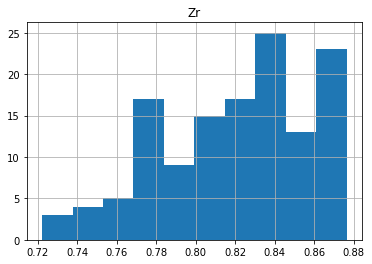

In [83]:
td = data[data['sample']=='PDAC_COM3_01255']
td.hist('Zr')

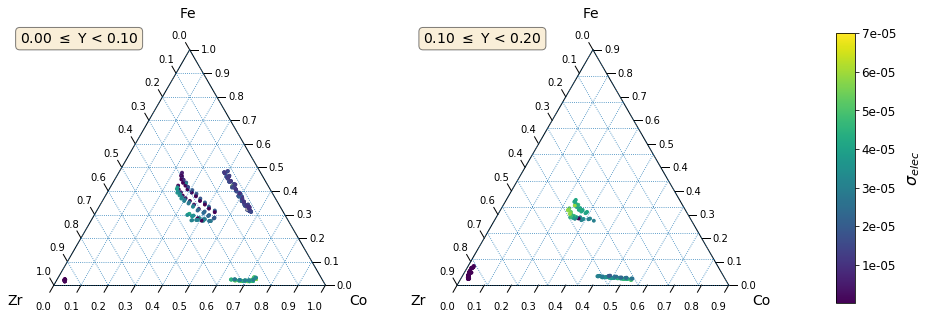

In [6]:
fig, axes = plt.subplots(1,2,figsize=(13,5))

fY_rng = [0,0.1]
dY = 0.1
for i, fY in enumerate(fY_rng):
    
    df = data[(data['Y'] >= fY) & (data['Y'] < fY +  dY)]

    points = df.loc[:,['Co','Fe','Zr']].values
    colors = df.loc[:,'Sigma_elec'].replace(np.nan,10).values
    vmin = np.min(colors)
    vmax = 7e-5#np.max(colors)

    ax=axes[i]

    scale = 1 - fY #point coords must sum to scale
    #since each comp has different Y value, need to scale points to plot scale
    ptsum = np.sum(points,axis=1)[np.newaxis].T
    scaled_pts = points*scale/ptsum

    #tfig, tax = ternary.figure(scale=scale,ax=ax)
    tax = ternary.TernaryAxesSubplot(scale=scale,ax=ax)
    cmap = plt.cm.viridis
    #cmap.set_bad('gray',1.) #doesn't seem to work
    cmap.set_over('darkgray',1.) #make nans grey
    tax.scatter(scaled_pts,s=8,colormap=cmap, vmin=vmin,vmax=vmax,
                colorbar=False,c=colors)
    tax.boundary(linewidth=1.0)
    tax.clear_matplotlib_ticks()
    tax.ticks(axis='lbr', linewidth=1, multiple=scale/10, tick_formats='%.1f',offset=0.03)
    tax.gridlines(multiple=0.1,linewidth=0.8)
    tax.bottom_axis_label('Co',offset=0.1,fontsize=14, position=(1.05,0.03,0))
    tax.right_axis_label('Fe',offset=0.2,fontsize=14, position=(-0.13,1.25,0), rotation=0)
    tax.left_axis_label('Zr',offset=0.2,fontsize=14, position=(-0.10,0.03,1), rotation=0)

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    tax.set_title('{0:.2f} $\leq$ Y < {1:.2f}'.format(fY,min(fY+dY,0.3)),fontsize=14,x=0.13,y=0.97, bbox=props)
    tax._redraw_labels()
    ax.axis('off')

#add a single colorbar
#make an axis for colorbar to control position/size
cbaxes = fig.add_axes([0.9,0.15,0.02,0.75]) #[left, bottom, width, height]
#code from colormapping.colorbar_hack
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cb = fig.colorbar(sm, ax=axes, cax = cbaxes,format='%.0e')
cb.set_label('$\sigma_{elec}$', fontsize=16, labelpad=10)
cb.ax.tick_params(labelsize=12)

fig.subplots_adjust(left=0.05,wspace=0.35, hspace=0.25, right=0.8)

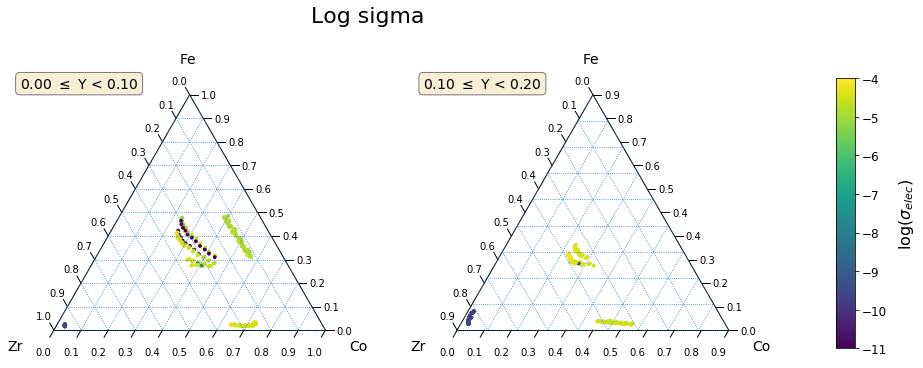

In [7]:
fig, axes = plt.subplots(1,2,figsize=(13,5))

vmin = -11
vmax = -4

fY_rng = [0,0.1]
dY = 0.1
for i, fY in enumerate(fY_rng):
    
    df = data[(data['Y'] >= fY) & (data['Y'] < fY +  dY)]

    points = df.loc[:,['Co','Fe','Zr']].values
    colors = np.log10(df.loc[:,'Sigma_elec'].replace(np.nan,10).values)


    ax=axes[i]

    scale = 1 - fY #point coords must sum to scale
    #since each comp has different Y value, need to scale points to plot scale
    ptsum = np.sum(points,axis=1)[np.newaxis].T
    scaled_pts = points*scale/ptsum

    #tfig, tax = ternary.figure(scale=scale,ax=ax)
    tax = ternary.TernaryAxesSubplot(scale=scale,ax=ax)
    cmap = plt.cm.viridis
    #cmap.set_bad('gray',1.) #doesn't seem to work
    cmap.set_over('darkgray',1.) #make nans grey
    tax.scatter(scaled_pts,s=8,colormap=cmap, vmin=vmin,vmax=vmax,
                colorbar=False,c=colors)
    tax.boundary(linewidth=1.0)
    tax.clear_matplotlib_ticks()
    tax.ticks(axis='lbr', linewidth=1, multiple=scale/10, tick_formats='%.1f',offset=0.03)
    tax.gridlines(multiple=0.1,linewidth=0.8)
    tax.bottom_axis_label('Co',offset=0.1,fontsize=14, position=(1.05,0.03,0))
    tax.right_axis_label('Fe',offset=0.2,fontsize=14, position=(-0.13,1.25,0), rotation=0)
    tax.left_axis_label('Zr',offset=0.2,fontsize=14, position=(-0.10,0.03,1), rotation=0)

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    tax.set_title('{0:.2f} $\leq$ Y < {1:.2f}'.format(fY,min(fY+dY,0.3)),fontsize=14,x=0.13,y=0.97, bbox=props)
    tax._redraw_labels()
    ax.axis('off')

#add a single colorbar
#make an axis for colorbar to control position/size
cbaxes = fig.add_axes([0.9,0.15,0.02,0.75]) #[left, bottom, width, height]
#code from colormapping.colorbar_hack
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cb = fig.colorbar(sm, ax=axes, cax = cbaxes)
cb.set_label('log($\sigma_{elec}$)', fontsize=16, labelpad=10)
cb.ax.tick_params(labelsize=12)

plt.suptitle("Log sigma",size=22,x=0.4,y=1.1)
fig.subplots_adjust(left=0.05,wspace=0.35, hspace=0.25, right=0.8)

In [57]:
#refresh modules
import sys
del sys.modules['helpers.plotting']
del quat_slice_scatter, quat_slice_heatmap, add_colorbar, sliceformula_from_tuple, rescale_ticks
from helpers.plotting import quat_slice_scatter, quat_slice_heatmap, add_colorbar, sliceformula_from_tuple, rescale_ticks

0.95


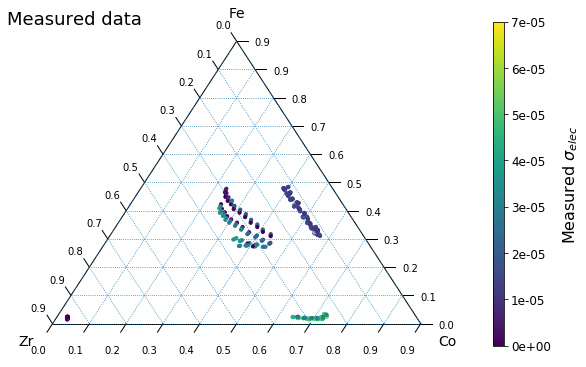

In [155]:
vmin = 0
vmax = 7e-5
slice_start = 0
slice_width = 0.1
quat_slice_scatter(data,z='Sigma_elec',slice_start=slice_val,slice_width=slice_width,slice_axis='Y',
                   tern_axes=['Co','Fe','Zr'],vmin=vmin,vmax=vmax,figsize=[7.5,6],
                   ptsize=10)

plt.title('Measured data',size=18,x=0.1)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured $\sigma_{elec}$',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.0e')

In [38]:
(1 - (slice_val+slice_width)/2)/5

0.19

0.95
0.85


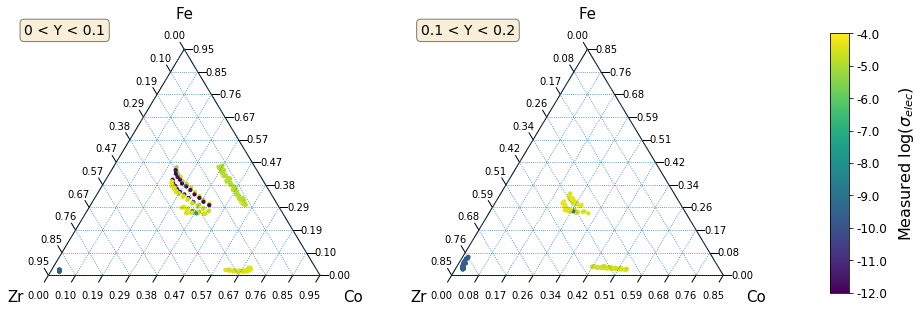

In [31]:
vmin = -12
vmax = -4
fig, axes = plt.subplots(1,2,figsize=[13,4.8])
slice_starts = [0, 0.1]
slice_width = 0.1
slice_axis='Y'
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    quat_slice_scatter(data,z='log_sigma',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=10,nticks=10,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2f','offset':0.03})
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=14,x=0.1,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured log($\sigma_{elec}$)',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.1f',ax=axes, 
             subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.8})

0.965
0.895
0.825


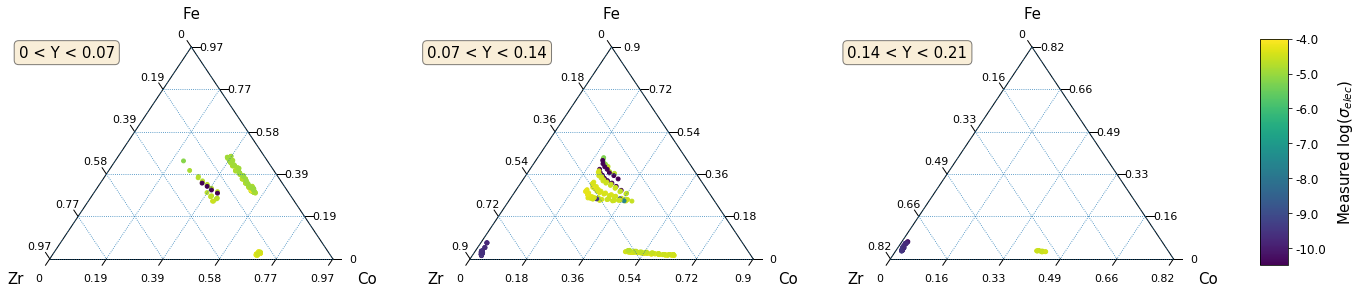

In [84]:
vmin = -10.5
vmax = -4
fig, axes = plt.subplots(1,3,figsize=(20,4.5))
slice_starts = [0., 0.07, 0.14]
slice_width = 0.07
slice_axis='Y'
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    quat_slice_scatter(data,z='log_sigma',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=15, nticks=5,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2g','offset':0.03,'fontsize':11})
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=15,x=0.1,y=0.9,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured log($\sigma_{elec}$)',labelkwargs={'size':15,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.1f',ax=axes, cbrect=[0.9,0.18,0.02,0.7],
                subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.85})
#fig.subplots_adjust(top=0.7)
#fig.suptitle('Experimental log($\sigma_{elec}$)',size=18)
plt.savefig(os.path.join(plotdir,'exp_logsigma_sliceY.png'),dpi=500)

0.85
0.7
0.1499999999999999


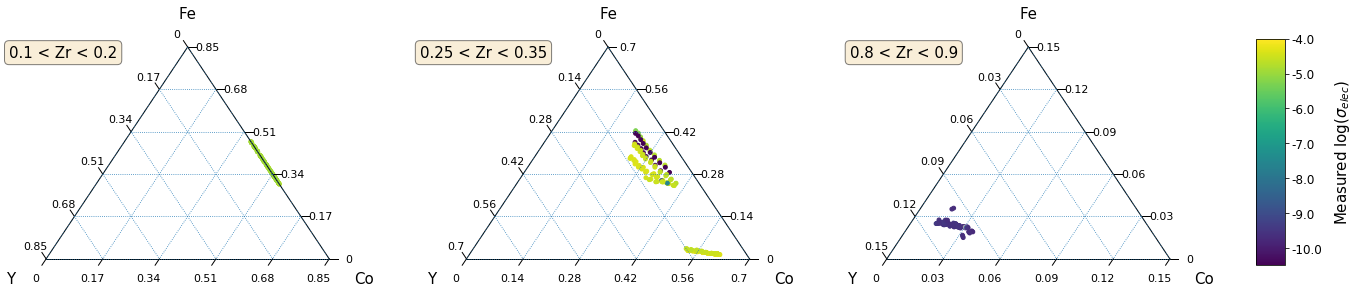

In [75]:
vmin = -10.5
vmax = -4
fig, axes = plt.subplots(1,3,figsize=(20,4.5))
slice_starts = [0.1, 0.25, 0.8]
slice_width = 0.1
slice_axis='Zr'
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    quat_slice_scatter(data,z='log_sigma',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Y'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=15, nticks=5,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2g','offset':0.03,'fontsize':11})
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=15,x=0.1,y=0.9,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured log($\sigma_{elec}$)',labelkwargs={'size':15,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.1f',ax=axes, cbrect=[0.9,0.18,0.02,0.7],
                subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.85})
#fig.subplots_adjust(top=0.7)
#fig.suptitle('Experimental log($\sigma_{elec}$)',size=18)
plt.savefig(os.path.join(plotdir,'exp_logsigma_sliceZr.png'),dpi=500)

0.965
0.895


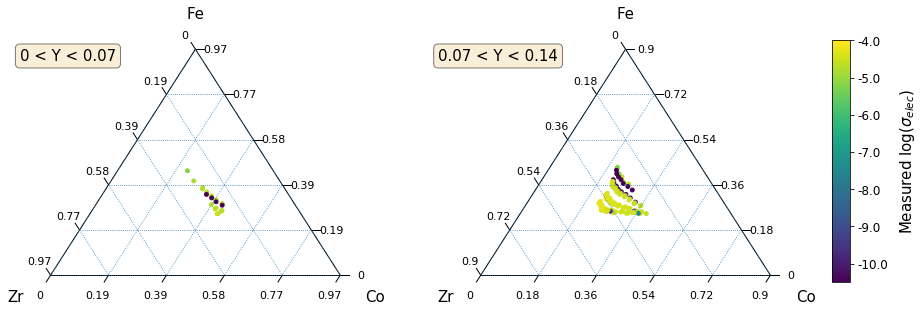

In [95]:
tdata = data.loc[data['sample']=='PDAC_COM3_01254',:]
vmin = -10.5
vmax = -4
fig, axes = plt.subplots(1,2,figsize=(13,4.8))
slice_starts = [0.0, 0.07]
slice_width = 0.07
slice_axis='Y'
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    quat_slice_scatter(tdata,z='log_sigma',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=15, nticks=5,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2g','offset':0.03,'fontsize':11})
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=15,x=0.1,y=0.9,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured log($\sigma_{elec}$)',labelkwargs={'size':15,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.1f',ax=axes, cbrect=[0.9,0.18,0.02,0.7],
                subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.85})
#fig.subplots_adjust(top=0.7)
#fig.suptitle('Experimental log($\sigma_{elec}$)',size=18)
plt.savefig(os.path.join(plotdir,'01254_logsigma_sliceY.png'),dpi=500)

0.75
0.65


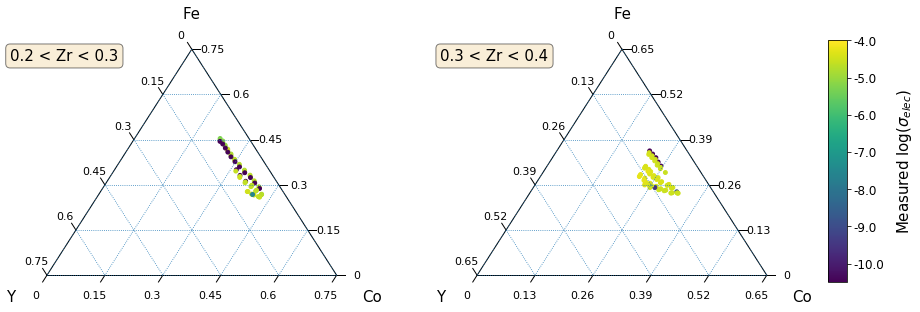

In [103]:
tdata = data.loc[data['sample']=='PDAC_COM3_01254',:]
vmin = -10.5
vmax = -4
fig, axes = plt.subplots(1,2,figsize=(13,4.8))
slice_starts = [0.2, 0.3]
slice_width = 0.1
slice_axis='Zr'

for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    quat_slice_scatter(tdata,z='log_sigma',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Y'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=15, nticks=5,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2g','offset':0.03,'fontsize':11})
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=15,x=0.1,y=0.9,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured log($\sigma_{elec}$)',labelkwargs={'size':15,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.1f',ax=axes, cbrect=[0.9,0.18,0.02,0.7],
                subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.85})
#fig.subplots_adjust(top=0.7)
#fig.suptitle('Experimental log($\sigma_{elec}$)',size=18)
#plt.savefig(os.path.join(plotdir,'01254_logsigma_sliceZr.png'),dpi=500)

Text(0,0.5,'Frequency')

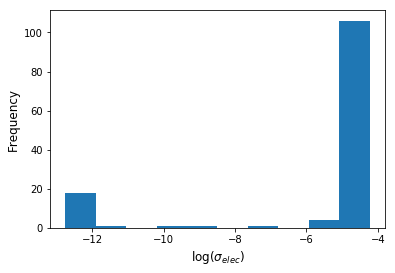

In [109]:
plt.hist(tdata['log_sigma'])
plt.xlabel('log($\sigma_{elec}$)',size=12)
plt.ylabel('Frequency',size=12)

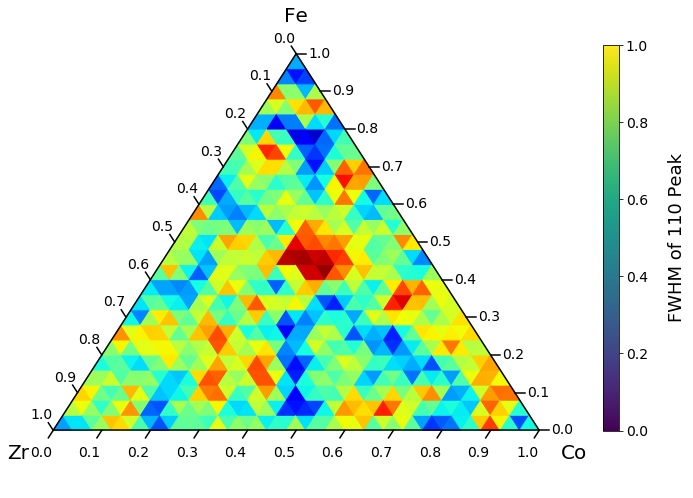

In [11]:
tuple_scale = 25
axis_scale = 1
tuples = []
zvals = []
for tup in simplex_iterator(scale=tuple_scale):
    #formula = sliceformula_from_tuple(tup,slice_val=0)
    #print(tup, formula)
    tuples.append(tup)
    zvals.append(np.random.rand())

d = dict(zip([t[0:2] for t in tuples],zvals))

fig, tax = ternary.figure(scale=tuple_scale)
fig.set_size_inches(11,8)

tax.heatmap(d,style='triangular',colorbar=False,cmap=plt.cm.jet)
rescale_ticks(tax,new_scale=axis_scale,multiple=0.1,tick_formats='%.1f',offset=0.02,fontsize=14)
tax.boundary()
tax.ax.axis('off')
tax.right_corner_label('Co',fontsize=20)
tax.top_corner_label('Fe',fontsize=20)
tax.left_corner_label('Zr',fontsize=20)

vmin=0
vmax=1
cmap=plt.cm.viridis
cbaxes = fig.add_axes([0.85,0.2,0.02,0.67]) #[left, bottom, width, height]
#code from colormapping.colorbar_hack
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cb = fig.colorbar(sm, ax=tax.ax, cax = cbaxes)
cb.set_label('FWHM of 110 Peak', fontsize=18, labelpad=20)
cb.ax.tick_params(labelsize=14)
fig.subplots_adjust(right=0.8)

tax._redraw_labels()


In [393]:
def formula_input(formula,cat_ox_lims={}):
    pvskt = perovskite(formula,site_ox_lim={'A':[2,4],'B':[2,4]},site_base_ox={'A':2,'B':4})
    for k,v in cat_ox_lims.items():
        pvskt.set_cat_ox_lim(k,v)
    pvskt.featurize()
    red_feat = {'Property {}'.format(k):v for (k,v) in pvskt.features.items() 
                if k[-5:] not in ['oxmin','oxmax'] and k[0:7]!='O_delta'}

    base_inp = {'Atmosphere':'dry','Temperature ($^\circ$C)':473}
    inp_dict = {**base_inp,**red_feat}
    return inp_dict

def heatmap_inputs(cat_ox_lims={},tuple_scale = 20,slice_axis='Y',slice_vals = [0,0.05,0.1],Ba = 0.9,tern_axes=['Co','Fe','Zr']):
    inputs = {}

    for slice_val in slice_vals:
        for tup in simplex_iterator(scale=tuple_scale):
            formula = sliceformula_from_tuple(tup=tup,slice_val=slice_val,slice_axis=slice_axis,tern_axes=tern_axes,Ba=Ba)
            inp_dict = formula_input(formula)
            inputs[(slice_val,tup)] = inp_dict
            
    return inputs

In [24]:
tup = (0,1,2)
def randomz(tup):
    return tup[0]*10 + tup[1]*5 + tup[2]*1

(TernaryAxesSubplot: 141055099144, 10, 100)

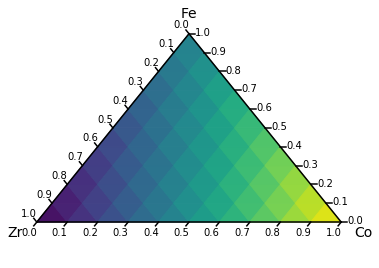

In [25]:
quat_slice_heatmap(tuple_scale=10,zfunc=randomz,slice_val=0)
#add_colorbar()

In [394]:
# tuple_scale = 20
# slice_axis='Y'
# slice_vals = [0,0.05,0.1]
# Ba = 0.9
# inputs = {}

# for slice_val in slice_vals:
#     for tup in simplex_iterator(scale=tuple_scale):
#         formula = sliceformula_from_tuple(tup=tup,slice_val=slice_val,slice_axis=slice_axis,tern_axes=['Co','Fe','Zr'],Ba=Ba)
#         inp_dict = formula_input(formula)
#         inputs[(slice_val,tup)] = inp_dict
Co24Fe24 = heatmap_inputs()
Co23Fe34 = heatmap_inputs(cat_ox_lims={'Co':[2,3],'Fe':[3,4]})

In [386]:
# client = CitrinationClient(os.environ['CITRINATION_API_KEY'],'https://citrination.com')

results_4999 = client.predict('4999',list(Co23Fe34.values())) #all samples, Co[2,3]Fe[3,4]
results_5002 = client.predict('5002',list(Co23Fe34.values())) #excluding 01255
results_5014 = client.predict('5014',list(Co24Fe24.values())) #all samples, Co[2,4]Fe[2,4]


sigma_4999 = [res.get_value('Property $\\sigma_{elec}$').value for res in results_4999]
sigma_5002 = [res.get_value('Property $\\sigma_{elec}$').value for res in results_5002]
sigma_5014 = [res.get_value('Property $\\sigma_{elec}$').value for res in results_5014]
sigma_4999_dict = dict(zip(inputs.keys(),sigma_4999))
sigma_5002_dict = dict(zip(inputs.keys(),sigma_5002))
sigma_5014_dict = dict(zip(inputs.keys(),sigma_5014))
    

In [335]:
def slicetup_lookup(tup,slice_val,dict):
    return dict[(slice_val,tup)]

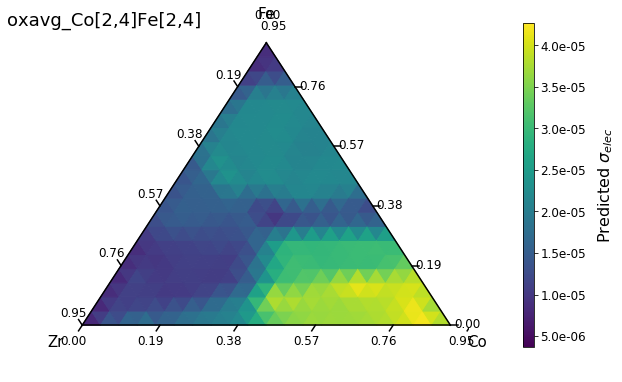

In [402]:
tax, vmin, vmax = quat_slice_heatmap(tuple_scale=20,zfunc=slicetup_lookup,slice_val=0.1,
                                     zfunc_kwargs={'dict':sigma_5014_dict,'slice_val':0.1},
                                    figsize=(7.5,6), labelsize=15, multiple=0.19,
                                     tick_kwargs={'tick_formats': '%.2f', 'offset': 0.02,'fontsize':12} )

plt.title('oxavg_Co[2,4]Fe[2,4]',size='18',x=0.1)

add_colorbar(vmin=vmin,vmax=vmax,label='Predicted $\sigma_{elec}$',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.1e')

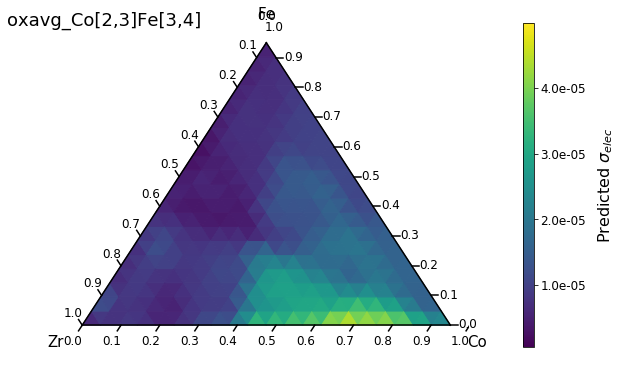

In [397]:
tax, vmin, vmax = quat_slice_heatmap(tuple_scale=20,zfunc=slicetup_lookup,slice_val=0.05,
                                     zfunc_kwargs={'dict':sigma_4999_dict,'slice_val':0.05},
                                    figsize=(7.5,6), labelsize=15,
                                     tick_kwargs={'tick_formats': '%.1f', 'offset': 0.02,'fontsize':12} )

plt.title('oxavg_Co[2,3]Fe[3,4]',size='18',x=0.1)

add_colorbar(vmin=vmin,vmax=vmax,label='Predicted $\sigma_{elec}$',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.1e')

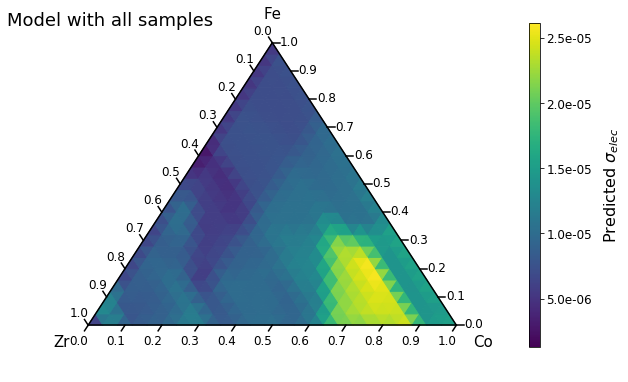

In [312]:
tax, vmin, vmax = quat_slice_heatmap(tuple_scale=25,zfunc=tup_lookup,slice_val=0,zfunc_kwargs={'lkp_dict':sigma_4999_dict},
                                    figsize=(7.5,6), labelsize=15,
                                     tick_kwargs={'tick_formats': '%.1f', 'offset': 0.02,'fontsize':12} )

plt.title('Model with all samples',size='18',x=0.1)

add_colorbar(vmin=vmin,vmax=vmax,label='Predicted $\sigma_{elec}$',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.1e')

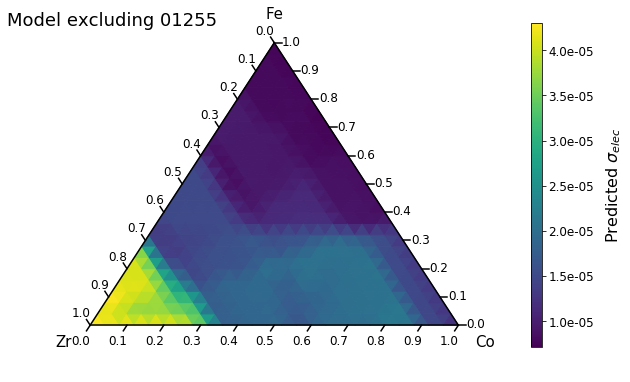

In [313]:
tax, vmin, vmax = quat_slice_heatmap(tuple_scale=25,zfunc=tup_lookup,slice_val=0,zfunc_kwargs={'lkp_dict':sigma_5002_dict},
                                    figsize=(7.5,6), labelsize=15,
                                     tick_kwargs={'tick_formats': '%.1f', 'offset': 0.02,'fontsize':12} )

plt.title('Model excluding 01255',size='18',x=0.1)

add_colorbar(vmin=vmin,vmax=vmax,label='Predicted $\sigma_{elec}$',labelkwargs={'size':16,'labelpad':10},
             tickparams={'labelsize':12}, tickformat='%.1e')


In [287]:
help(quat_slice_heatmap)

Help on function quat_slice_heatmap in module __main__:

quat_slice_heatmap(tuple_scale, zfunc, slice_val, zfunc_kwargs={}, style='triangular', slice_axis='Y', tern_axes=['Co', 'Fe', 'Zr'], tern_labels=None, labelsize=14, cmap=<matplotlib.colors.ListedColormap object at 0x000001EFA3A16668>, ax=None, figsize=None, vmin=None, vmax=None, tick_kwargs={'multiple': 0.1, 'tick_formats': '%.1f', 'offset': 0.02})



In [208]:
dir(results[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_values',
 'add_value',
 'all_keys',
 'get_value']

In [403]:
test = {'a':0,'b':1}
len(test)

2

In [202]:
cand = client.predict(view_id,inp_dict)['candidates']

TypeError: list indices must be integers or slices, not str